Notre problème est : 

\begin{align*}
\ \ min_{X,u} \ &   \alpha_{0} T + \alpha_{1} \int_{0}^{T}u_{1}^2 dt + \alpha_{2} \int_{0}^{T}u_{2}^2 dt + \alpha_{3} \int_{0}^{T}u_{3}^2 dt    \\
s.c \ & \dot{x} = cos(\theta)v_{avant} - sin(\theta)v_{orth} \\
& \dot{y} = sin(\theta)v_{avant} + cos(\theta)v_{orth}  \\
& \dot{\theta} = w  \\
& \dot{v}_{avant} = u_1  \\
& \dot{w} = u_2  \\
& \dot{v}_{orth} = u_3  \\
& X(0) = X_0  \ \ et \ \  X(T) = X_{final}
\end{align*}

#### Notation :
$ \Delta t = \frac{T}{n}  $

$ x[i]  : = x(i \Delta t )   \ \forall i \in \{1,...,n \} $   

#### Remarque : 
On va approché notre intégrale par la méthode des triangles.

Prenons une subdivision de notre interval [0,T] en n sous intervalle. Nous allons transformer notre problème continue en un problème discret et de plus on va transformer nos équations diférentielle par un dévéloppement limité. 

Par exemple $ \frac{x[i+1]+x[i]}{\Delta t} $  qui est une approximation de $ \dot{x}[i]  \ \ (donc \ \ \dot{x}[i] := \frac{x[i+1]+x[i]}{\Delta t} $)



Soit $ \Delta t = \frac{T}{n}  $
\begin{align*}
(2)  \ \  \ min_{X(i),u(i)} \ &   \Delta t  \sum_{i=1}^{n} ( \alpha_{0} + \alpha_{1} u_{1}^2[i]+ \alpha_{2} u_{2}^2[i] + \alpha_{3}u_{3}^2[i]  )   \\
s.c \ &  \forall i \in \{1,...,n \}  \\
& x[i+1] = x[i] + \Delta t(cos(\theta[i])v_{1}[i] - sin(\theta[i])v_{2}[i]) \\
& y[i+1] = y[i] + \Delta t(sin(\theta[i])v_{1}[i] + cos(\theta[i])v_{2}[i])  \\
& \theta[i+1] = \theta[i] + \Delta t (w[i])  \\
& u_1[i] = \frac{v_{1}[i+1] - v_{1}[i] }{ \Delta t}  \\
& u_2[i] = \frac{w[i+1] - w[i]}{\Delta t}   \\
& u_3[i] = \frac{v_{2}[i+1] - v_{2}[i] }{\Delta t }  \\
& X[0] = X_0  \ \ et \ \  X[T] = X_{final}
\end{align*}

#### REMARQUE :  
Si un poids $α_i$ est grand, le terme correspondant a un  effet important sur la somme globale et donc est plus susceptible d’être réduit  dans le contexte global. Si $α_i$ est petit (ou égal à zéro), le terme a peu  (ou pas) d’influence sur la fonction objective et les quantités peuvent devenir  grandes sans faire beaucoup de mal. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import random as random
%matplotlib inline
from casadi import *


In [2]:
def tracer_orientation (x,y,theta, r, i):
    if i == 1 :
        plt.arrow(x, y, r*cos(theta),r*sin(theta), width = 0.01, color = 'red' , label = "Axe local suivant x")
        plt.arrow(x, y, r*cos(pi/2+theta),r*sin(pi/2+theta), width = 0.01, color = 'yellow' , label = "Axe local suivant y")
        plt.legend()
    else :
        plt.arrow(x, y, r*cos(theta),r*sin(theta), width = 0.01, color = 'red' )
        plt.arrow(x, y, r*cos(pi/2+theta),r*sin(pi/2+theta), width = 0.01, color = 'yellow' )
    

## DOC  $ (Contrôle\ optimal\ direct)$

In [3]:
n = 500
T = 2.5
taux = T/n

Times = np.linspace(0, T, n)

#### Exemple 1 

In [9]:
alpha1 = 0.15
alpha2 = 0.25
alpha3 = 0.6

x0 = -4
y0 = -0.9
theta0 = pi

xf = 0
yf = 0
thetaf = pi/2

In [10]:
## variable de position
x = SX.sym('x', n )
y = SX.sym('y', n )
theta = SX.sym('theta', n )

## variable de vitesse 
v1 = SX.sym('v1', n )
v2 = SX.sym('v2', n )
w = SX.sym('w', n )


## variable de accélération 
u1 = SX.sym('u1', n )
u2 = SX.sym('u2', n )
u3 = SX.sym('u3', n )


#### Fonctions utile

In [11]:
f= Function('f',[x],[x[1:]])

p =vertcat(v1[1:],0)
g = Function ('g',[v1],[p])

In [12]:
phi = Function ('phi', [u1,u2,u3], [ taux*( alpha1 * dot(u1,u1 ) + alpha2 * dot(u2 ,u2 ) + alpha3 * dot(u3 ,u3))]) 

In [14]:
opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

## les positions
x = opti.variable(n)
y = opti.variable(n)
theta = opti.variable(n)

## les vitesses 
v1 = opti.variable(n)        ## vitesse latérale
v2 = opti.variable(n)        ## vitesse orthogonal
w = opti.variable(n)         ## vitesse angulaire


## les accélération 
u1 = opti.variable(n)        ## accélération latérale
u3 = opti.variable(n)        ## accélération orthogonal
u2 = opti.variable(n)        ## accélération angulaire


opti.minimize(  taux*(alpha1 * dot(u1,u1) + alpha2 * dot(u2,u2 ) + alpha3 * dot( u3 ,u3 ) ) )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

## pour les condition initial
opti.subject_to( x[0] == x0)       
opti.subject_to( y[0] == y0)    
opti.subject_to( theta[0] == theta0)

        
opti.subject_to( v1[0] == 0.0001 )
opti.subject_to( w[0] == 0.0001 )
opti.subject_to( v2[0] == 0.0001 )
opti.subject_to( v1[-1] == 0.0001 )
opti.subject_to( w[-1] == 0.0001 )
opti.subject_to( v2[-1] == 0.0001 )

opti.subject_to( u1[-1] == 0.0001 )
opti.subject_to( u2[-1] == 0.0001 )
opti.subject_to( u3[-1] == 0.0001 )

opti.subject_to( u1[0] == 0.0001 )
opti.subject_to( u2[0] == 0.0001 )
opti.subject_to( u3[0] == 0.0001 )



    ## pour les contraintes d'égaliter
opti.subject_to( x[1:] == x[:n-1]+taux*(cos(theta[:n-1])*v1[:n-1] - sin(theta[:n-1])*v2[:n-1]) )
opti.subject_to( y[1:] == y[:n-1]+taux*(sin(theta[:n-1])*v1[:n-1] + cos(theta[:n-1])*v2[:n-1]) )
opti.subject_to( theta[1:] == theta[:n-1] + taux*w[:n-1] )
opti.subject_to( (v1[:n-1] + taux* u1[:n-1] == v1[1:])  )
opti.subject_to( (v2[:n-1] + taux* u3[:n-1] == v2[1:]) )
opti.subject_to( (w[:n-1] + taux* u2[:n-1] == w[1:]) )
    

    ## pour les conditions finales
opti.subject_to( x[-1]==xf)
opti.subject_to( y[-1]==yf)
opti.subject_to( theta[-1]==thetaf)


opti.solver('ipopt')      # suivant la méthode de KKT

sol = opti.solve()

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2997

Total number of variables............................:     4500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3012
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [15]:
U1_0 = sol.value(u1)
U2_0 = sol.value(u2)
U3_0 = sol.value(u3)
V1_0 = sol.value(v1)
W_0 = sol.value(w)
V2_0 = sol.value(v2)
X_0 = sol.value(x)
Y_0 = sol.value(y)
THETA_0 = sol.value(theta)

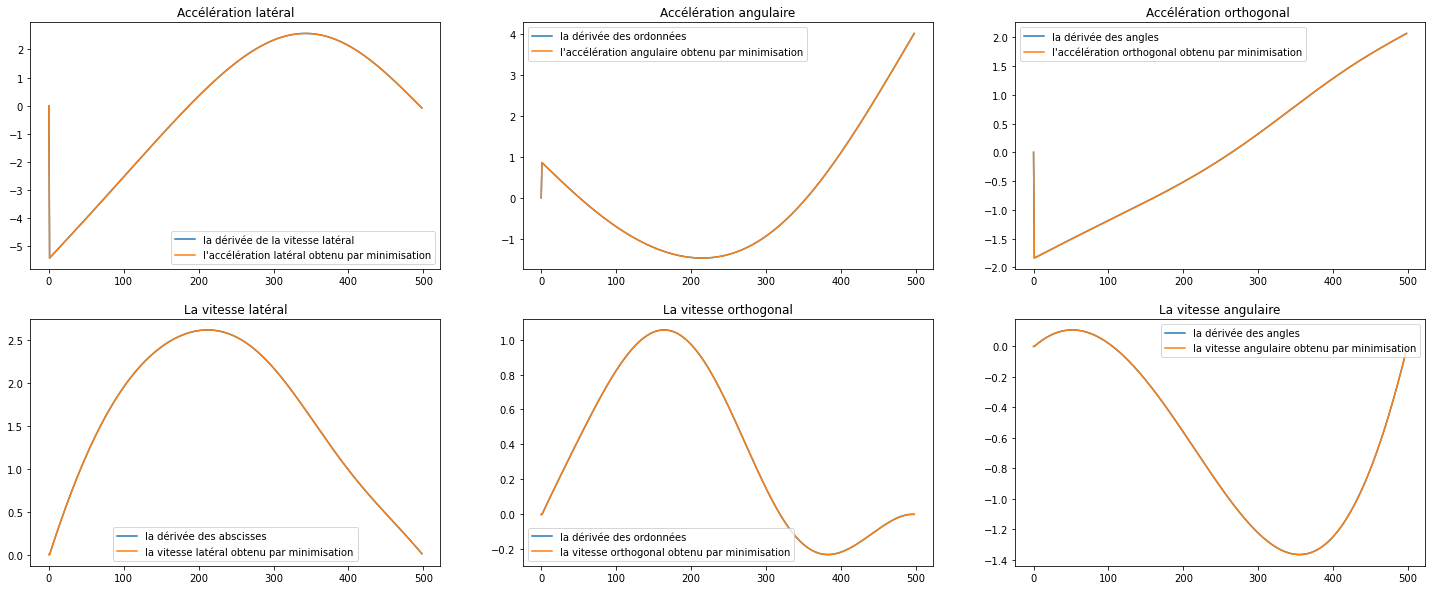

In [16]:
X1_1 = (V1_0[1:]-V1_0[:n-1])/taux
X1_2 = (W_0[1:]-W_0[:n-1])/taux
X1_3 = (V2_0[1:]-V2_0[:n-1])/taux
XX_1 = (cos(THETA_0[:n-1])*V1_0[:n-1] - sin(THETA_0[:n-1])*V2_0[:n-1])
XX_2 = (sin(THETA_0[:n-1])*V1_0[:n-1] + cos(THETA_0[:n-1])*V2_0[:n-1])
XX_3 = (THETA_0[1:]-THETA_0[:n-1])/taux

Y1_1 = U1_0[:n-1]
Y1_2 = U2_0[:n-1]
Y1_3 = U3_0[:n-1]
YY_1 = (X_0[1:]-X_0[:n-1])/taux
YY_2 = (Y_0[1:]-Y_0[:n-1])/taux
YY_3 = W_0[:n-1]



plt.subplots(figsize=(25, 10))

plt.subplot(2,3,1)
plt.plot(X1_1, label = "la dérivée de la vitesse latéral")
plt.plot(Y1_1, label = "l'accélération latéral obtenu par minimisation")
plt.title("Accélération latéral")
plt.legend()


plt.subplot(2,3,2)
plt.plot(X1_2, label = "la dérivée des ordonnées")
plt.plot(Y1_2, label = "l'accélération angulaire obtenu par minimisation")
plt.title("Accélération angulaire")
plt.legend()


plt.subplot(2,3,3)
plt.plot(X1_3, label = "la dérivée des angles")
plt.plot(Y1_3, label = "l'accélération orthogonal obtenu par minimisation")
plt.title("Accélération orthogonal ")
plt.legend()


plt.subplot(2,3,4)
plt.plot(XX_1, label = "la dérivée des abscisses")
plt.plot(YY_1, label = "la vitesse latéral obtenu par minimisation")
plt.title("La vitesse latéral")
plt.legend()


plt.subplot(2,3,5)
plt.plot(XX_2, label = "la dérivée des ordonnées")
plt.plot(YY_2, label = "la vitesse orthogonal obtenu par minimisation")
plt.title("La vitesse orthogonal")
plt.legend()



plt.subplot(2,3,6)
plt.plot(XX_3, label = "la dérivée des angles")
plt.plot(YY_3, label = "la vitesse angulaire obtenu par minimisation")
plt.title("La vitesse angulaire")
plt.legend()


In [17]:
F = np.zeros(n)

for i in range (n):
    F[i] = phi(U1_0[i], U2_0[i], U3_0[i])

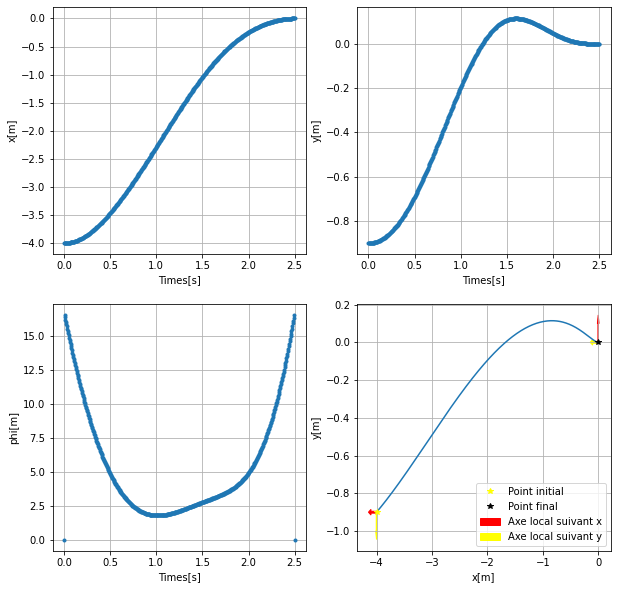

In [18]:
plt.subplots(figsize=(10, 10))

plt.subplot(2, 2, 1) 
plt.plot (Times,X_0 , '.')
plt.xlabel('Times[s]')
plt.ylabel('x[m]')
plt.grid(True)

plt.subplot(2, 2, 2) 
plt.plot (Times,Y_0 , '.')
plt.xlabel('Times[s]')
plt.ylabel('y[m]')
plt.grid(True)

plt.subplot(2, 2, 3) 
plt.plot (Times,F , '.')
plt.xlabel('Times[s]')
plt.ylabel('phi[m]')
plt.grid(True)

plt.subplot(2, 2, 4) 
plt.plot (X_0,Y_0 )
plt.plot(x0,y0, '*', label = 'Point initial', color = 'yellow')
plt.plot(xf,yf, '*', label = 'Point final', color = 'black')

tracer_orientation (X_0[0],Y_0[0],THETA_0[0], 0.1,0)

#tracer_orientation (X_0[40],Y_0[40],THETA_0[40],0.1,0)
#tracer_orientation (X_0[150],Y_0[150],THETA_0[150],0.1,0)

#tracer_orientation (X_0[250],Y_0[250],THETA_0[250],0.1,0)

tracer_orientation (X_0[-1],Y_0[-1],THETA_0[-1],0.1,1)


plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.grid(True)
plt.legend()

#### Exemple 2 

In [19]:
alpha1 = 0.85
alpha2 = 0.05
alpha3 = 0.1

In [20]:
x0 = -1.5
y0 = 1.2
theta0 = pi/10

xf = 0
yf = 0
thetaf = 0

In [21]:
opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

## les positions
x = opti.variable(n)
y = opti.variable(n)
theta = opti.variable(n)

## les vitesses 
v1 = opti.variable(n)        ## vitesse latérale
v2 = opti.variable(n)        ## vitesse orthogonal
w = opti.variable(n)         ## vitesse angulaire


## les accélération 
u1 = opti.variable(n)        ## accélération latérale
u3 = opti.variable(n)        ## accélération orthogonal
u2 = opti.variable(n)        ## accélération angulaire


opti.minimize(  taux*(alpha1 * dot(u1,u1) + alpha2 * dot(u2,u2 ) + alpha3 * dot( u3 ,u3 ) ) )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

    ## pour les condition initial
## pour les condition initial
opti.subject_to( x[0] == x0)       
opti.subject_to( y[0] == y0)    
opti.subject_to( theta[0] == theta0)

        
opti.subject_to( v1[0] == 0.0001 )
opti.subject_to( w[0] == 0.0001 )
opti.subject_to( v2[0] == 0.0001 )
opti.subject_to( v1[-1] == 0.0001 )
opti.subject_to( w[-1] == 0.0001 )
opti.subject_to( v2[-1] == 0.0001 )

opti.subject_to( u1[-1] == 0.0001 )
opti.subject_to( u2[-1] == 0.0001 )
opti.subject_to( u3[-1] == 0.0001 )

opti.subject_to( u1[0] == 0.0001 )
opti.subject_to( u2[0] == 0.0001 )
opti.subject_to( u3[0] == 0.0001 )



    ## pour les contraintes d'égaliter
opti.subject_to( x[1:] == x[:n-1]+taux*(cos(theta[:n-1])*v1[:n-1] - sin(theta[:n-1])*v2[:n-1]) )
opti.subject_to( y[1:] == y[:n-1]+taux*(sin(theta[:n-1])*v1[:n-1] + cos(theta[:n-1])*v2[:n-1]) )
opti.subject_to( theta[1:] == theta[:n-1] + taux*w[:n-1] )
opti.subject_to( (v1[:n-1] + taux* u1[:n-1] == v1[1:])  )
opti.subject_to( (v2[:n-1] + taux* u3[:n-1] == v2[1:]) )
opti.subject_to( (w[:n-1] + taux* u2[:n-1] == w[1:]) )
    

    ## pour les conditions finales
opti.subject_to( x[-1]==xf)
opti.subject_to( y[-1]==yf)
opti.subject_to( theta[-1]==thetaf)


opti.solver('ipopt')      # suivant la méthode de KKT

sol = opti.solve()

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2997

Total number of variables............................:     4500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3012
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.50e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [22]:
U1_2 = sol.value(u1)
U2_2 = sol.value(u2)
U3_2 = sol.value(u3)
V1_2 = sol.value(v1)
W_2 = sol.value(w)
V2_2 = sol.value(v2)
X_2 = sol.value(x)
Y_2 = sol.value(y)
THETA_2 = sol.value(theta)

F = np.zeros(n)

for i in range (n):
    F[i] = phi(V1_2[i], W_2[i], V2_2[i])

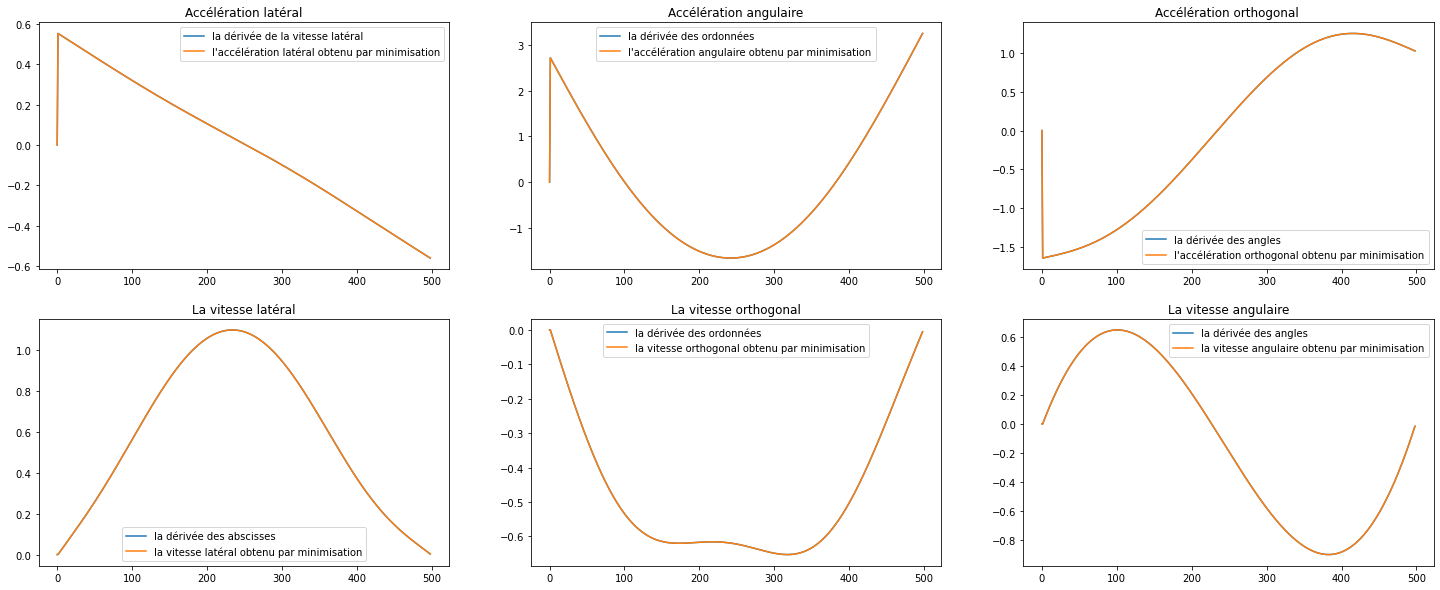

In [23]:
X1_1 = (V1_2[1:]-V1_2[:n-1])/taux
X1_2 = (W_2[1:]-W_2[:n-1])/taux
X1_3 = (V2_2[1:]-V2_2[:n-1])/taux
XX_1 = (cos(THETA_2[:n-1])*V1_2[:n-1] - sin(THETA_2[:n-1])*V2_2[:n-1])
XX_2 = (sin(THETA_2[:n-1])*V1_2[:n-1] + cos(THETA_2[:n-1])*V2_2[:n-1])
XX_3 = (THETA_2[1:]-THETA_2[:n-1])/taux

Y1_1 = U1_2[:n-1]
Y1_2 = U2_2[:n-1]
Y1_3 = U3_2[:n-1]
YY_1 = (X_2[1:]-X_2[:n-1])/taux
YY_2 = (Y_2[1:]-Y_2[:n-1])/taux
YY_3 = W_2[:n-1]



plt.subplots(figsize=(25, 10))

plt.subplot(2,3,1)
plt.plot(X1_1, label = "la dérivée de la vitesse latéral")
plt.plot(Y1_1, label = "l'accélération latéral obtenu par minimisation")
plt.title("Accélération latéral")
plt.legend()


plt.subplot(2,3,2)
plt.plot(X1_2, label = "la dérivée des ordonnées")
plt.plot(Y1_2, label = "l'accélération angulaire obtenu par minimisation")
plt.title("Accélération angulaire")
plt.legend()


plt.subplot(2,3,3)
plt.plot(X1_3, label = "la dérivée des angles")
plt.plot(Y1_3, label = "l'accélération orthogonal obtenu par minimisation")
plt.title("Accélération orthogonal ")
plt.legend()


plt.subplot(2,3,4)
plt.plot(XX_1, label = "la dérivée des abscisses")
plt.plot(YY_1, label = "la vitesse latéral obtenu par minimisation")
plt.title("La vitesse latéral")
plt.legend()


plt.subplot(2,3,5)
plt.plot(XX_2, label = "la dérivée des ordonnées")
plt.plot(YY_2, label = "la vitesse orthogonal obtenu par minimisation")
plt.title("La vitesse orthogonal")
plt.legend()



plt.subplot(2,3,6)
plt.plot(XX_3, label = "la dérivée des angles")
plt.plot(YY_3, label = "la vitesse angulaire obtenu par minimisation")
plt.title("La vitesse angulaire")
plt.legend()


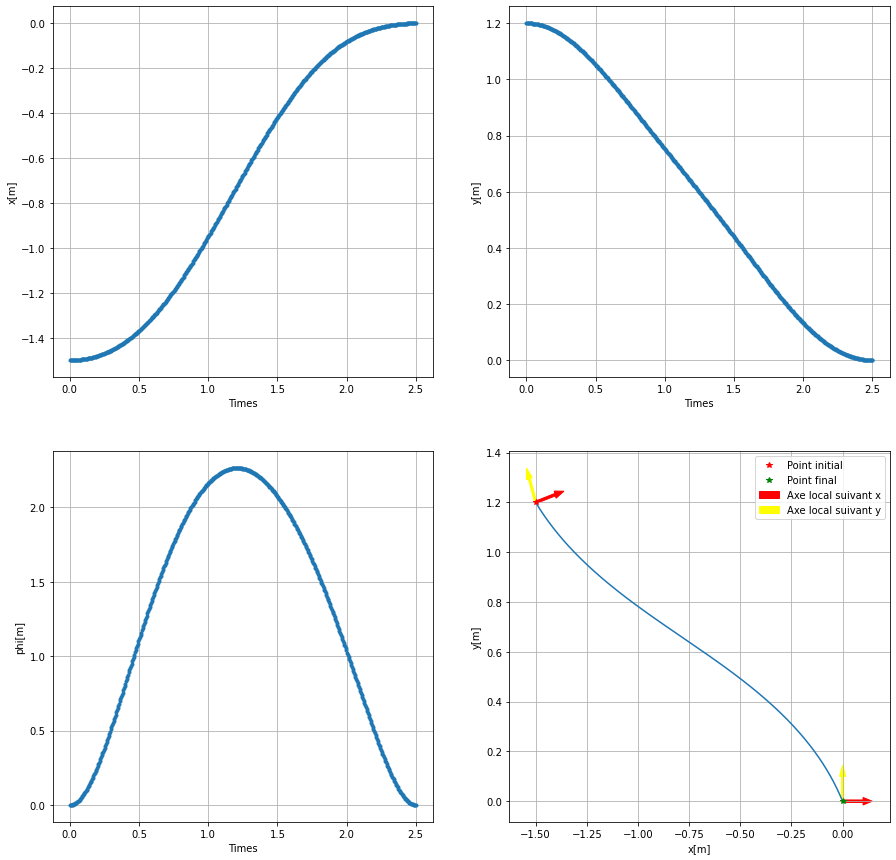

In [24]:
plt.subplots(figsize=(15, 15))

plt.subplot(2, 2, 1) 
plt.plot (Times,X_2 , '.')
plt.xlabel('Times')
plt.ylabel('x[m]')
plt.grid(True)

plt.subplot(2, 2, 2) 
plt.plot (Times,Y_2 , '.')
plt.xlabel('Times')
plt.ylabel('y[m]')
plt.grid(True)


plt.subplot(2, 2, 3) 
plt.plot (Times,F , '.')
plt.xlabel('Times')
plt.ylabel('phi[m]')
plt.grid(True)

plt.subplot(2, 2, 4) 
plt.plot (X_2,Y_2 )
plt.plot(x0,y0, '*', label = 'Point initial', color = 'red')
plt.plot(xf,yf, '*', label = 'Point final', color = 'green')

tracer_orientation (X_2[0],Y_2[0],THETA_2[0], 0.1,0)

#tracer_orientation (X_2[40],Y_2[40],THETA_2[40],0.1,0)
#tracer_orientation (X_2[150],Y_2[150],THETA_2[150],0.1,0)

#tracer_orientation (X_2[250],Y_2[250],THETA_2[250],0.1,0)

tracer_orientation (X_2[-1],Y_2[-1],THETA_2[-1],0.1,1)


plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.grid(True)
plt.legend()

## IOC $(Contrôle\ optimal\ inverse)$

In [25]:
xi = SX.sym('xi',1)                   
yi = SX.sym('yi',1)                
thetai = SX.sym('thetai',1)


xf = SX.sym('xf',1)
yf = SX.sym('yf',1)
thetaf = SX.sym('thetaf',1)

### Pour les trois première contrainte.

In [27]:
alpha1 = SX.sym('alpha1',1)
alpha2 = SX.sym('alpha2',1)
alpha3 = SX.sym('alpha3',1)

## Position
x=SX.sym('x',n)
x_prime = SX.sym('x_prime', n+1)
x_prime[0] = x[0]
x_prime[1:] =x


y=SX.sym('y',n)
y_prime = SX.sym('y_prime', n+1)
y_prime[0] = y[0]
y_prime[1:] =y

theta=SX.sym('theta',n)
theta_prime = SX.sym('theta_prime', n+1)
theta_prime[0] = theta[0]
theta_prime[1:] =theta


## Vitesse
v1=SX.sym('v1',n)  
v1_prime = SX.sym('v1_prime', n+1)
v1_prime[0] = 0
v1_prime[n] = 0
v1_prime[1:n] =v1[0:n-1]

v1_prime_1 = SX.sym('v1_prime_1', n+1)
v1_prime_1[0] = v1[0]
v1_prime_1[1:] =v1


v2=SX.sym('v2',n)  
v2_prime = SX.sym('v2_prime', n+1)
v2_prime[0] = 0
v2_prime[n] = 0
v2_prime[1:n] =v2[0:n-1]

v2_prime_1 = SX.sym('v2_prime_1', n+1)
v2_prime_1[0] = v2[0]
v2_prime_1[1:] =v2


w=SX.sym('w',n)  
w_prime = SX.sym('w_prime', n+1)
w_prime[0] = 0
w_prime[n] = 0
w_prime[1:n] =w[0:n-1]

w_prime_1 = SX.sym('w_prime_1', n+1)
w_prime_1[0] = w[0]
w_prime_1[1:] =w


## Accélération 

u1=SX.sym('u1',n)  
u1_prime = SX.sym('u1_prime', n+1)
u1_prime[0] = 0
u1_prime[n] = 0
u1_prime[1:n] = u1[0:n-1]

u2=SX.sym('u2',n)  
u2_prime = SX.sym('u2_prime', n+1)
u2_prime[0] = 0
u2_prime[n] = 0
u2_prime[1:n] = u2[0:n-1]

u3=SX.sym('u3',n)  
u3_prime = SX.sym('u3_prime', n+1)
u3_prime[0] = 0
u3_prime[n] = 0
u3_prime[1:n] = u3[0:n-1]

Lambda = SX.sym('Lambda',n+3, 6)


In [28]:
p1=vertcat(xi,x_prime[2:],xf)   # Je définis un nouveau vecteur suivant x1 en prenant les n-1 dernières valeurs 
                               #  et la nième valeur vaut x1f
h= Function('h',[x, xi, xf],[p1])

p2=vertcat(0, v1)   
K = Function('K', [v1], [p2])


In [29]:
Y1_K = (x_prime+taux*(v1_prime*cos(theta_prime) - v2_prime*sin(theta_prime)) - h(x, xi,xf))
Y2_K = (y_prime+taux*(v1_prime*sin(theta_prime) + v2_prime*cos(theta_prime)) - h(y, yi,yf)) 
Y3_K = (theta_prime+taux*w_prime - h(theta, thetai,thetaf))

U1 = (g(v1)-v1)/taux - u1
U2 = (g(w)-w)/taux  - u2
U3 = (g(v2)-v2)/taux  - u3 

Y4_K = K(U1) 
Y5_K = K(U2)
Y6_K = K(U3)



Y_K = SX.sym('Y_K',n+1 , 6)        ## notre contrainte

for i in range (0,n+1):
    Y_K[i,0]= Y1_K[i]
    Y_K[i,1]= Y2_K[i]
    Y_K[i,2]= Y3_K[i]       
    Y_K[i,3]= Y4_K[i]       
    Y_K[i,4]= Y5_K[i]       
    Y_K[i,5]= Y6_K[i]       
    
## notre terme qui est relié a la contrainte.
G_lambda = 0

for i in range (n+1):
    G_lambda += dot(Y_K[i,:], Lambda[i,:])
    
G_lambda += (v1[0]-0.0001)*Lambda[n+1,0] + (w[0]-0.0001)*Lambda[n+1,1] + (v2[0]-0.0001)*Lambda[n+1,2] 
G_lambda += (v1[-1]-0.0001)*Lambda[n+1,3] + (w[-1]-0.0001)*Lambda[n+1,4] + (v2[-1]-0.0001)*Lambda[n+1,5] 

G_lambda += (u1[0]-0.0001)*Lambda[n+2,0] + (u2[0]-0.0001)*Lambda[n+2,1] + (u3[0]-0.0001)*Lambda[n+2,2] 
G_lambda += (u1[-1]-0.0001)*Lambda[n+2,3] + (u2[-1]-0.0001)*Lambda[n+2,4] + (u3[-1]-0.0001)*Lambda[n+2,5] 

In [30]:
F_val_K =  taux*( alpha1 * dot(u1,u1) + alpha2 * dot(u2,u2) + alpha3 * dot(u3,u3))

## le Lagrangien 
L_val_K = F_val_K + G_lambda

In [31]:
grad_L_K = SX.zeros(9, n)
for i in range (n):
    grad_L_K[0,i]= jacobian(L_val_K, v1[i])
    grad_L_K[1,i]= jacobian(L_val_K, w[i])
    grad_L_K[2,i]= jacobian(L_val_K, v2[i])
    grad_L_K[3,i]= jacobian(L_val_K, x[i])
    grad_L_K[4,i]= jacobian(L_val_K, y[i])
    grad_L_K[5,i]= jacobian(L_val_K, theta[i])
    grad_L_K[6,i]= jacobian(L_val_K, u1[i])
    grad_L_K[7,i]= jacobian(L_val_K, u2[i])
    grad_L_K[8,i]= jacobian(L_val_K, u3[i])
    
    
    
R_K = Function ('R_K', [u1,u2,u3,v1,w,v2,x,y,theta, Lambda, alpha1, alpha2, alpha3 ,xi,yi,thetai, xf,yf,thetaf  ], [dot(grad_L_K,grad_L_K)])
    

###  Exemple 1

In [32]:
alpha1 = 0.15
alpha2 = 0.25
alpha3 = 0.6

x0 = -4
y0 = -0.9
theta0 = pi

xf = 0
yf = 0
thetaf = pi/2

In [34]:

opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème


alpha1 = opti.variable()
alpha2 = opti.variable()
alpha3 = opti.variable()


Lambda = opti.variable(n+3,6)


opti.minimize( R_K(U1_0, U2_0, U3_0,V1_0,W_0,V2_0,X_0,Y_0,THETA_0, Lambda, alpha1, alpha2, alpha3,  x0,y0,theta0, xf,yf,thetaf )) 

opti.subject_to( 0 <= alpha1)
#opti.subject_to( 1 >= alpha1)

opti.subject_to( 0 <= alpha2 )
#opti.subject_to( 1 >= alpha2)

opti.subject_to( 0 <= alpha3 )
#opti.subject_to( 1 >= alpha3)

opti.subject_to(  alpha1 + alpha2 + alpha3 == 1)

opti.solver('ipopt')    

sol = opti.solve()

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        3
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:    15021

Total number of variables............................:     3021
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [35]:
print(sol.value(alpha1))
print(sol.value(alpha2))
print(sol.value(alpha3))

0.15002613403543524
0.24996936795574745
0.6000044980088173


#### Exemple 2

In [36]:
alpha1 = 0.85
alpha2 = 0.05
alpha3 = 0.1

x0 = -1.5
y0 = 1.2
theta0 = pi/10

xf = 0
yf = 0
thetaf = 0

In [37]:
opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème


alpha1 = opti.variable()
alpha2 = opti.variable()
alpha3 = opti.variable()


Lambda = opti.variable(n+3,6)


opti.minimize( R_K(U1_2, U2_2, U3_2,V1_2,W_2,V2_2,X_2,Y_2,THETA_2, Lambda, alpha1, alpha2, alpha3,  x0,y0,theta0, xf,yf,thetaf )) 


opti.subject_to( 0 <= alpha1)
opti.subject_to( 0 <= alpha2 )
opti.subject_to( 0 <= alpha3 )
opti.subject_to(  alpha1 + alpha2 + alpha3 == 1)



opti.solver('ipopt')    

sol = opti.solve()

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        3
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:    15021

Total number of variables............................:     3021
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [38]:
print(sol.value(alpha1))
print(sol.value(alpha2))
print(sol.value(alpha3))

0.8499959753327978
0.04999963194151783
0.10000439272568433


## Ajoutant du bruit 

In [39]:
sigma = np.logspace(-5,0, 100)      ## notre écart_type 

In [40]:
def évolution_residue (sigma, U1, U2,U3, V1,W,V2, X, Y, THETA , Xi, Xf, n) :
    Res = np.zeros(100)
    Alpha1_prime = np.zeros(100)
    Alpha2_prime = np.zeros(100)
    Alpha3_prime = np.zeros(100)
    

    x0 = Xi[0]
    y0 = Xi[1]
    theta0 = Xi[2]
    
    xf = Xf[0]
    yf = Xf[1]
    thetaf = Xf[2]
       

    for i in range (100):
        U1__1 = U1 + np.random.normal (0, sigma[i], size =n)
        U2__1 = U2 + np.random.normal (0, sigma[i], size =n)
        U3__1 = U3 + np.random.normal (0, sigma[i], size =n)

        V1__1 = V1 + np.random.normal (0, sigma[i], size =n)
        W__1 = W + np.random.normal (0, sigma[i], size =n)
        V2__1 = V2 + np.random.normal (0, sigma[i], size =n)

        X__1 = X + np.random.normal (0, sigma[i], size =n)
        Y__1 = Y + np.random.normal (0, sigma[i], size =n)
        THETA__1 = THETA + np.random.normal (0, sigma[i], size =n)


        opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème


        alpha1 = opti.variable()
        alpha2 = opti.variable()
        alpha3 = opti.variable()


        Lambda = opti.variable(n+3,6)

        
        opti.minimize( R_K(U1__1, U2__1, U3__1,V1__1,W__1,V2__1,X__1,Y__1,THETA__1, Lambda, alpha1, alpha2, alpha3,  x0,y0,theta0, xf,yf,thetaf )) 

    
        opti.subject_to( 0 <= alpha1)
        opti.subject_to( 0 <= alpha2 )
        opti.subject_to( 0 <= alpha3 )
        opti.subject_to(  alpha1 + alpha2 + alpha3 == 1)

        opti.solver('ipopt')    

        sol = opti.solve()

        Alpha1_prime [i] = sol.value(alpha1)
        Alpha2_prime [i] = sol.value(alpha2)
        Alpha3_prime [i] = sol.value(alpha3)
        

        Res [i] = R_K(U1__1, U2__1, U3__1,V1__1,W__1,V2__1,X__1,Y__1,THETA__1, sol.value(Lambda), sol.value(alpha1), sol.value(alpha2), sol.value(alpha3),  x0,y0,theta0, xf,yf,thetaf )

        
    return Res , Alpha1_prime, Alpha2_prime, Alpha3_prime

In [41]:
def RMSE_vecteur ( Alpha1 ,Alpha2, Alpha3 ,U1, U2,U3, V1,W,V2, X, Y, THETA , Xi, Xf, n) :
     
    RMSE = np.zeros(100)
    
    x0 = Xi[0]
    y0 = Xi[1]
    theta0 = Xi[2]
    
    xf = Xf[0]
    yf = Xf[1]
    thetaf = Xf[2]
    

    for i in range (100):

        print('i = ' , i)

        opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

        ## les positions
        x = opti.variable(n)
        y = opti.variable(n)
        theta = opti.variable(n)

        ## les vitesses 
        v1 = opti.variable(n)        ## vitesse latérale
        v2 = opti.variable(n)        ## vitesse orthogonal
        w = opti.variable(n)         ## vitesse angulaire


        ## les accélération 
        u1 = opti.variable(n)        ## accélération latérale
        u3 = opti.variable(n)        ## accélération orthogonal
        u2 = opti.variable(n)        ## accélération angulaire


        opti.minimize(  taux*(Alpha1[i] * dot(u1,u1) + Alpha2[i] * dot(u2,u2 ) + Alpha3[i] * dot( u3 ,u3 ) ) )    # ma fonction objetion

            # mes fonctions de contrainte d'égalité:

            ## pour les condition initial
        opti.subject_to( x[0] == x0)        
        opti.subject_to( y[0] == y0)
        opti.subject_to( theta[0] == theta0)
        
        opti.subject_to( v1[0] == 0.0001 )
        opti.subject_to( w[0]  == 0.0001 )
        opti.subject_to( v2[0] == 0.0001 )
        opti.subject_to( v1[-1] == 0.0001 )
        opti.subject_to( w[-1]  == 0.0001 )
        opti.subject_to( v2[-1] == 0.0001 )

        opti.subject_to( u1[-1] == 0.0001 )
        opti.subject_to( u2[-1] == 0.0001 )
        opti.subject_to( u3[-1] == 0.0001 )
        opti.subject_to( u1[0] == 0.0001 )
        opti.subject_to( u2[0] == 0.0001 )
        opti.subject_to( u3[0] == 0.0001 )



            ## pour les contraintes d'égaliter
        opti.subject_to( x[1:] == x[:n-1]+taux*(cos(theta[:n-1])*v1[:n-1] - sin(theta[:n-1])*v2[:n-1]) )
        opti.subject_to( y[1:] == y[:n-1]+taux*(sin(theta[:n-1])*v1[:n-1] + cos(theta[:n-1])*v2[:n-1]) )
        opti.subject_to( theta[1:] == theta[:n-1] + taux*w[:n-1] )
        opti.subject_to( (v1[:n-1] + taux* u1[:n-1] == v1[1:])  )
        opti.subject_to( (v2[:n-1] + taux* u3[:n-1] == v2[1:]) )
        opti.subject_to( (w[:n-1] + taux* u2[:n-1] == w[1:]) )


            ## pour les conditions finales
        opti.subject_to( x[-1]==xf)
        opti.subject_to( y[-1]==yf)
        opti.subject_to( theta[-1]==thetaf)


        opti.solver('ipopt')      # suivant la méthode de KKT

        sol = opti.solve()

        RMSE [i] = np.sqrt ((np.linalg.norm(U1 - sol.value(u1))**2 + np.linalg.norm(U2 - sol.value(u2))**2 + np.linalg.norm(U3 - sol.value(u3))**2 + np.linalg.norm(V1 - sol.value(v1))**2  + np.linalg.norm(W - sol.value(w))**2 + + np.linalg.norm(V2 - sol.value(v2))**2 + np.linalg.norm(X - sol.value(x))**2 + np.linalg.norm(Y - sol.value(y))**2 + np.linalg.norm(THETA - sol.value(theta))**2 )/n )
        
    return RMSE


In [42]:
alpha1 = 0.85
alpha2 = 0.05
alpha3 = 0.1

x0 = -1.5
y0 = 1.2
theta0 = pi/10

xf = 0
yf = 0
thetaf = 0

In [43]:
Xi = np.array([x0,y0,theta0])
Xf = np.array([xf,yf,thetaf])


Res, Alpha1_prime, Alpha2_prime,Alpha3_prime = évolution_residue (sigma, U1_2, U2_2, U3_2,V1_2,W_2,V2_2,X_2,Y_2,THETA_2 , Xi, Xf, n)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        3
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:    15021

Total number of variables............................:     3021
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

Text(0.5, 1.0, "L'évolution du résidue en fonction de sigma")

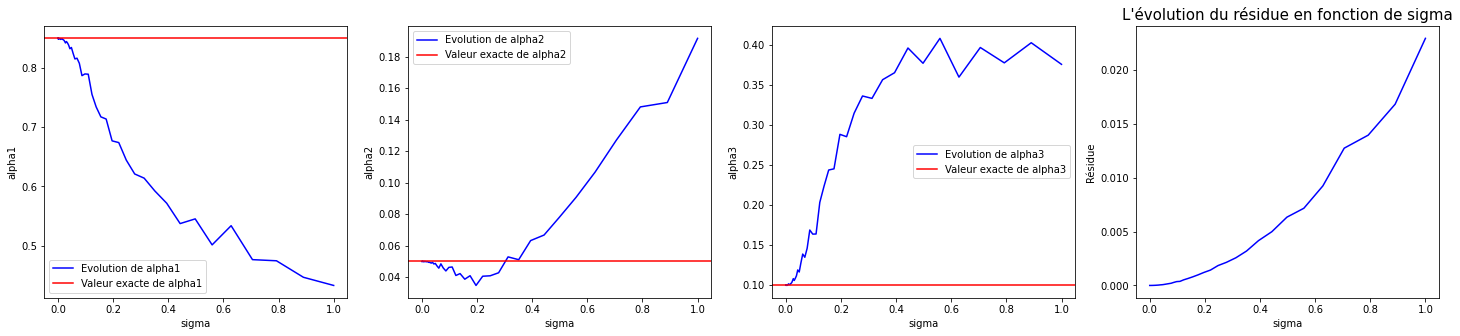

In [44]:
plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.plot(sigma, Alpha1_prime , label = "Evolution de alpha1" , color = 'b')
plt.axhline(alpha1, label = "Valeur exacte de alpha1", color = 'red')

plt.xlabel('sigma')
plt.ylabel('alpha1')
plt.legend()

plt.subplot(1,4,2)
plt.plot(sigma, Alpha2_prime , label = "Evolution de alpha2" , color = 'b')
plt.axhline(alpha2, label = "Valeur exacte de alpha2", color = 'red')

plt.xlabel('sigma')
plt.ylabel('alpha2')
plt.legend()

plt.subplot(1,4,3)
plt.plot(sigma, Alpha3_prime , label = "Evolution de alpha3" , color = 'b')
plt.axhline(alpha3, label = "Valeur exacte de alpha3", color = 'red')

plt.xlabel('sigma')
plt.ylabel('alpha3')
plt.legend()

plt.subplot(1,4,4)
plt.plot(sigma, Res , color = 'b')
plt.xlabel('sigma')
plt.ylabel('Résidue')
plt.title("L'évolution du résidue en fonction de sigma", size = '15')



In [45]:
RMSE_1 = RMSE_vecteur ( Alpha1_prime, Alpha2_prime, Alpha3_prime, U1_2, U2_2,U3_2, V1_2,W_2,V2_2, X_2, Y_2, THETA_2 , Xi, Xf, n)

i =  0
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2997

Total number of variables............................:     4500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3012
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.50e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.0

Text(0.5, 1.0, "L'évolution du RMSE entre la trajectoire initiale et celle bruité en fonction de sigma")

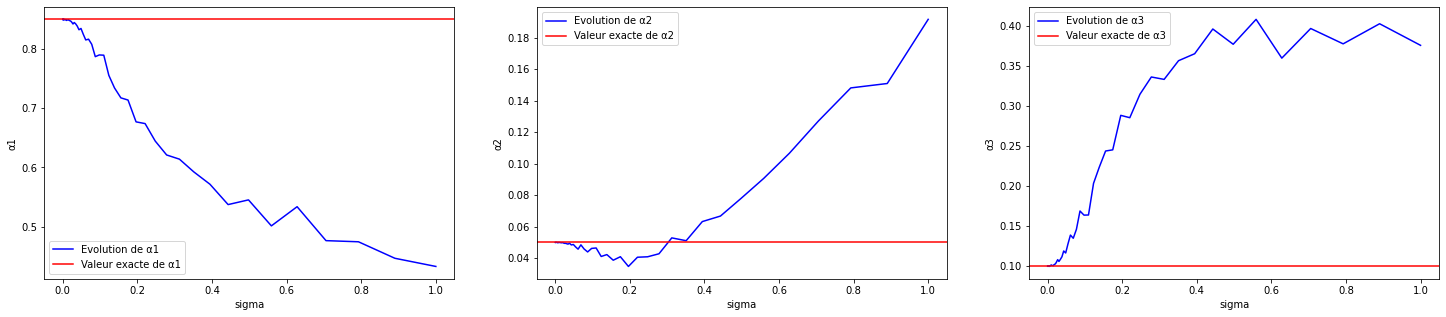

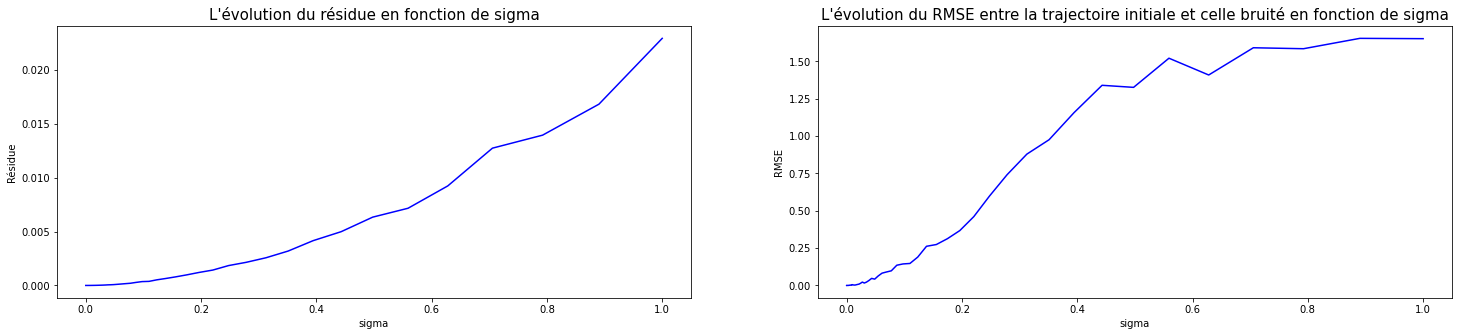

In [46]:
plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
plt.plot(sigma, Alpha1_prime , label = "Evolution de α1" , color = 'b')
plt.axhline(alpha1, label = "Valeur exacte de α1", color = 'red')

plt.xlabel('sigma')
plt.ylabel('α1')
plt.legend()

plt.subplot(1,3,2)
plt.plot(sigma, Alpha2_prime , label = "Evolution de α2" , color = 'b')
plt.axhline(alpha2, label = "Valeur exacte de α2", color = 'red')

plt.xlabel('sigma')
plt.ylabel('α2')
plt.legend()

plt.subplot(1,3,3)
plt.plot(sigma, Alpha3_prime , label = "Evolution de α3" , color = 'b')
plt.axhline(alpha3, label = "Valeur exacte de α3", color = 'red')

plt.xlabel('sigma')
plt.ylabel('α3')
plt.legend()

plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
plt.plot(sigma, Res , color = 'b')
plt.xlabel('sigma')
plt.ylabel('Résidue')
plt.title("L'évolution du résidue en fonction de sigma", size = '15')

plt.subplot(1,2,2)
plt.plot(sigma, RMSE_1  , color = 'b')
plt.xlabel('sigma')
plt.ylabel('RMSE')
plt.title("L'évolution du RMSE entre la trajectoire initiale et celle bruité en fonction de sigma", size = '15')

## TEST SUR UNE TRAJECTOIRE

In [71]:
U1__1 = U1_0 + np.random.normal (0, 0.1, size =n)
U2__1 = U2_0 + np.random.normal (0, 0.1, size =n)
U3__1 = U3_0 + np.random.normal (0, 0.1, size =n)
V1__1 = V1_0 + np.random.normal (0, 0.1, size =n)
V2__1 = V2_0 + np.random.normal (0, 0.1, size =n)
W__1 = W_0 + np.random.normal (0, 0.1, size =n)
X__1 = X_0 + np.random.normal (0, 0.1, size =n)
Y__1 = Y_0 + np.random.normal (0, 0.1, size =n)
THETA__1 = THETA_0 + np.random.normal (0, 0.1, size =n)

In [72]:
alpha1 = 0.15
alpha2 = 0.25
alpha3 = 0.6
x0 = -4
y0 = -0.9
theta0 = -pi/2

xf = 0
yf = 0
thetaf = pi/2

opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème


alpha1 = opti.variable()
alpha2 = opti.variable()
alpha3 = opti.variable()


Lambda = opti.variable(n+3,6)

opti.minimize( R_K(U1__1, U2__1, U3__1,V1__1,W__1,V2__1,X__1,Y__1,THETA__1, Lambda,  alpha1, alpha2, alpha3,  x0,y0,theta0, xf,yf,thetaf )) 

opti.subject_to( 0 <= alpha1)
#opti.subject_to( 1 >= alpha1)

opti.subject_to( 0 <= alpha2 )
#opti.subject_to( 1 >= alpha2)


opti.subject_to( 0 <= alpha3 )
#opti.subject_to( 1 >= alpha3)


opti.subject_to(  alpha1 + alpha2 + alpha3 == 1)



opti.solver('ipopt')    

sol = opti.solve()

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        3
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:    15003

Total number of variables............................:     3015
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [73]:
Alpha1 = sol.value(alpha1)
Alpha2 = sol.value(alpha2)
Alpha3 = sol.value(alpha3)

In [74]:
opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

## les positions
x = opti.variable(n)
y = opti.variable(n)
theta = opti.variable(n)

## les vitesses 
v1 = opti.variable(n)        ## vitesse latérale
v2 = opti.variable(n)        ## vitesse orthogonal
w = opti.variable(n)         ## vitesse angulaire


## les accélération 
u1 = opti.variable(n)        ## accélération latérale
u3 = opti.variable(n)        ## accélération orthogonal
u2 = opti.variable(n)        ## accélération angulaire


opti.minimize(  taux*(Alpha1 * dot(u1,u1) + Alpha2 * dot(u2,u2 ) + Alpha3 * dot( u3 ,u3 ) ) )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

    ## pour les condition initial
opti.subject_to( x[0] == x0)        
opti.subject_to( y[0] == y0)
opti.subject_to( theta[0] == theta0)

opti.subject_to( v1[0] == 0.0001 )
opti.subject_to( w[0]  == 0.0001 )
opti.subject_to( v2[0] == 0.0001 )
opti.subject_to( v1[-1] == 0.0001 )
opti.subject_to( w[-1]  == 0.0001 )
opti.subject_to( v2[-1] == 0.0001 )

opti.subject_to( u1[-1] == 0.0001 )
opti.subject_to( u2[-1] == 0.0001 )
opti.subject_to( u3[-1] == 0.0001 )

opti.subject_to( u1[0] == 0.0001 )
opti.subject_to( u2[0] == 0.0001 )
opti.subject_to( u3[0] == 0.0001 )



    ## pour les contraintes d'égaliter
opti.subject_to( x[1:] == x[:n-1]+taux*(cos(theta[:n-1])*v1[:n-1] - sin(theta[:n-1])*v2[:n-1]) )
opti.subject_to( y[1:] == y[:n-1]+taux*(sin(theta[:n-1])*v1[:n-1] + cos(theta[:n-1])*v2[:n-1]) )
opti.subject_to( theta[1:] == theta[:n-1] + taux*w[:n-1] )
opti.subject_to( (v1[:n-1] + taux* u1[:n-1] == v1[1:])  )
opti.subject_to( (v2[:n-1] + taux* u3[:n-1] == v2[1:]) )
opti.subject_to( (w[:n-1] + taux* u2[:n-1] == w[1:]) )
    

    ## pour les conditions finales
opti.subject_to( x[-1]==xf)
opti.subject_to( y[-1]==yf)
opti.subject_to( theta[-1]==thetaf)


opti.solver('ipopt')      # suivant la méthode de KKT

sol = opti.solve()

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:    10996
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2997

Total number of variables............................:     4500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3009
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [75]:
X1 = sol.value(x)
X2 = sol.value(y)

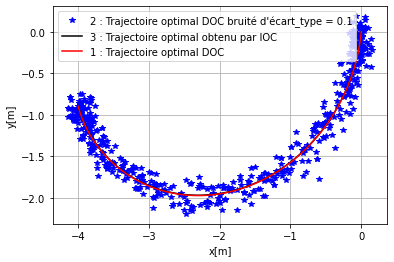

In [78]:
plt.plot(X__1, Y__1 ,'*', color = 'b', label = "2 : Trajectoire optimal DOC bruité d'écart_type = 0.1")
plt.plot(X1, X2 , color = 'black', label = "3 : Trajectoire optimal obtenu par IOC")
plt.plot(X_0, Y_0 , color = 'red', label = '1 : Trajectoire optimal DOC')

plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.grid(True)
plt.legend()

In [77]:
Alpha1 , Alpha2 , Alpha3

(0.1518823475670683, 0.2550652602256013, 0.5930523922073304)